## <center>CSE 546: Reinforcement Learning</center>
### <center>Prof. Alina Vereshchaka</center>
<!-- ### <center>Fall 2022</center> -->

The Assignment 2, Part 2: In the second part of the assignment we will explore the Gymnasium library and implement
Deep Q-learning (DQN) following DeepMind’s paper that explains how RL algorithms can learn to play
Atari from raw pixels.

# **2.1 Implementing DQN & Solving grid-world environment**

**2.1.1 Setup & imports**

Brings in core Python utilities (OS, time, randomness, etc.), scientific stack (NumPy, PyTorch), and Gymnasium. Establishes the modules we'll use throughout DQN (nn/optim) and environment APIs (spaces).

In [ ]:
import os, math, random, time, collections, io, contextlib
from gymnasium.wrappers import RecordVideo
from dataclasses import dataclass
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from gymnasium import spaces
import torch.optim as optim
import gymnasium as gym
import torch.nn as nn
import numpy as np
import glob, os
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2.1.2 Reproducibility & device**

This cell ensures the selection of a GPU if available and fixes random seeds for Python, NumPy, and PyTorch to make runs repeatable. Prints the selected compute device.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 1227
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Device:", device)

Device: cpu


## **Grid-World env (from previous assignment)**

**2.1.3 Warehouse Environment - Configuration**

Defines `WarehouseConfig` with grid size, shelf locations, start/pickup/dropoff cells, reward structure, and episode cap. Acts as a single source of truth for environment parameters.

In [ ]:
# Configuration for the Warehouse Robot environment
class WarehouseConfig:
    n_rows = 6
    n_cols = 6

    # Obstacle layout
    shelves = [(1,2),(1,3),(2,3),(3,3),(4,1),(4,2)]

    # Key positions
    start = (0,0)
    pickup = (0,5)
    dropoff = (5,5)

    # Rewards
    step_penalty = -1
    obstacle_penalty = -20
    pickup_reward = +25
    deliver_reward = +100

    # to randomize start and the goal locations
    randomize_start  = False
    randomize_goals  = False

    max_steps = 500

**2.1.4 Warehouse Environment - Helper Functions**

Utility functions for bounds checking, shelf detection, observation packing/indexing (enables one-hot encoding), and an RGB frame builder (`warehouse_rgb_frame`) that turns the current grid state into an H×W×3 image. The RGB helper lets us preview the environment in color and record mp4 videos via Gymnasium’s `RecordVideo` wrapper.

In [ ]:
# Bounds check
def in_bounds(r, c, n_rows, n_cols):
    return 0 <= r < n_rows and 0 <= c < n_cols

# Shelf collision check
def is_shelf(cell, shelves):
    return tuple(cell) in shelves

# Observation encoder
def encode_obs(r, c, carrying):
    return (r, c, int(carrying))

# Observation index
def obs_to_index(obs, n_rows, n_cols):
    r, c, carry = obs
    base = r * n_cols + c
    return int(base + (n_rows * n_cols) * carry)

# RGB frame builder
def warehouse_rgb_frame(env, scale: int = 20):
    H, W = env.n_rows, env.n_cols
    img = np.ones((H, W, 3), dtype=np.float32)

    shelf   = np.array([0.55, 0.55, 0.55])
    pickup  = np.array([0.30, 0.80, 0.35])
    dropoff = np.array([0.30, 0.45, 0.90])
    agent_empty = np.array([0.90, 0.20, 0.20])  # red
    agent_carry = np.array([0.95, 0.55, 0.10])  # orange

    for (r, c) in env.shelves: img[r, c] = shelf
    pr, pc = env.pickup;  img[pr, pc] = pickup
    dr, dc = env.dropoff; img[dr, dc] = dropoff
    ar, ac = env.r, env.c; img[ar, ac] = agent_carry if env.carrying else agent_empty

    img_big = np.kron(img, np.ones((scale, scale, 1), dtype=np.float32))
    return (img_big * 255).astype(np.uint8)

**2.1.5 Warehouse Environment - Base Environment Class**

Declares action set and `WarehouseBase` (Gymnasium API): observation/action spaces, cached layout, reward constants, episode counters, `reset()`, and a text `render()`. Includes `_tick()` to update step count and episode return.

In [ ]:
# Movement actions (row, col) deltas
# 0: UP, 1: DOWN, 2: LEFT, 3: RIGHT, 4: PICK, 5: DROP
MOVE_ACTIONS = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
PICK, DROP = 4, 5
N_ACTIONS = 6

class WarehouseBase(gym.Env):

    metadata = {"render_modes": ["ansi", "rgb_array"]}

    def __init__(self, cfg, render_mode: str | None = None):
        super().__init__()
        self.cfg = cfg
        self.render_mode = render_mode

        # Spaces:

        # observation=(row, col, carry_flag)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(cfg.n_rows),
            spaces.Discrete(cfg.n_cols),
            spaces.Discrete(2)
        ))

        # action in {0..5}
        self.action_space = spaces.Discrete(N_ACTIONS)

        # Cache layout
        self.n_rows = int(cfg.n_rows)
        self.n_cols = int(cfg.n_cols)
        self.shelves = [tuple(x) for x in cfg.shelves]
        self.start = tuple(cfg.start)
        self.pickup = tuple(cfg.pickup)
        self.dropoff = tuple(cfg.dropoff)

        # Rewards
        self.step_penalty     = float(cfg.step_penalty)
        self.obstacle_penalty = float(cfg.obstacle_penalty)
        self.pickup_reward    = float(cfg.pickup_reward)
        self.deliver_reward   = float(cfg.deliver_reward)

        # Episode logging
        self.max_steps  = int(getattr(cfg, "max_steps", 500))
        self.t          = 0
        self.ep_return  = 0.0
        self.picked_once = False

        # Agent state
        self.r = None
        self.c = None
        self.carrying = False

        # Safety assertions
        assert self.start not in self.shelves,   "start cannot be on a shelf"
        assert self.pickup not in self.shelves,  "pickup cannot be on a shelf"
        assert self.dropoff not in self.shelves, "dropoff cannot be on a shelf"
        assert self.pickup != self.dropoff,      "pickup and dropoff must differ"

    def reset(self, seed=None, options=None):
        """
        Reset episode state to the configured start cell and clear flags.
        """
        super().reset(seed=seed)


        # Random goal locations (distinct, free cells)
        if getattr(self.cfg, "randomize_goals", False):
            free = [(r, c) for r in range(self.n_rows) for c in range(self.n_cols)
                      if (r, c) not in self.shelves]
            self.pickup = random.choice(free)
            free2 = [xy for xy in free if xy != self.pickup]
            self.dropoff = random.choice(free2)

        # Random starting locations (free and not pick/drop)
        if getattr(self.cfg, "randomize_start", False):
            free = [(r, c) for r in range(self.n_rows) for c in range(self.n_cols)
                      if (r, c) not in self.shelves and (r, c) != self.pickup and (r, c) != self.dropoff]
            self.r, self.c = random.choice(free)
        else:
            self.r, self.c = self.start

        # Reset flags & counters
        self.carrying   = False
        self.picked_once = False
        self.t          = 0
        self.ep_return  = 0.0

        obs = encode_obs(self.r, self.c, self.carrying)
        info = {}
        return obs, info

    def step(self, action):
        """
        Subclasses implement this.
        """
        raise NotImplementedError

    def _tick(self, reward):
        self.t += 1
        self.ep_return += float(reward)
        truncated = self.t >= self.max_steps
        return truncated

    def render(self):
        # RGB frames for RecordVideo
        if getattr(self, "render_mode", None) == "rgb_array":
            return warehouse_rgb_frame(self)

        # Draw from top row to bottom row
        lines = []
        for rr in range(self.n_rows):
            row_cells = []
            for cc in range(self.n_cols):
                ch = "."
                if (rr, cc) in self.shelves:
                    ch = "#"
                elif (rr, cc) == self.pickup:
                    ch = "P"
                elif (rr, cc) == self.dropoff:
                    ch = "D"
                if (rr, cc) == (self.r, self.c):
                    ch = "a" if self.carrying else "A"
                row_cells.append(f"[{ch}]")
            lines.append(" ".join(row_cells))
        # Print with top row first (row 0 at the top)
        print("\n".join(lines))
        print(f"pos=({self.r},{self.c}) carrying={self.carrying}")

**2.1.6 Warehouse Environment - Deterministic Environment**

Implements `WarehouseDeterministicEnv.step()`: processes movement with collision/penalties, pickup/drop rules, termination on delivery, and truncation via `_tick()`. Returns `(obs, reward, terminated, truncated, info)` with useful flags and episode stats.

In [ ]:
class WarehouseDeterministicEnv(WarehouseBase):

    def step(self, action):
        reward = self.step_penalty
        terminated = False
        blocked_oob = False # bloccked because the movement is out-of-bound
        blocked_shelf = False # blocked because the movement is into a shelf

        if action in MOVE_ACTIONS:
            dr, dc = MOVE_ACTIONS[action]
            nr, nc = self.r + dr, self.c + dc

            # bounds: reject illegal move (stay in place)
            if not in_bounds(nr, nc, self.n_rows, self.n_cols):
                blocked_oob = True
                nr, nc = self.r, self.c  # stay put

            # shelves: block and penalize (only if not out-of-bound)
            elif is_shelf((nr, nc), self.shelves):
                blocked_shelf = True
                reward += self.obstacle_penalty
                nr, nc = self.r, self.c  # stay put
            else:
                self.r, self.c = nr, nc

        elif action == PICK:
            if (self.r, self.c) == self.pickup and not self.carrying:
                self.carrying = True
                if not self.picked_once:
                    reward += self.pickup_reward
                    self.picked_once = True
            # else: silent, no operation (safety policy)

        elif action == DROP:
            if self.carrying and (self.r, self.c) == self.dropoff:
                reward += self.deliver_reward
                self.carrying = False
                terminated = True
            # else: silent, no operation

        # Step accounting & truncation
        truncated = self._tick(reward)

        obs = encode_obs(self.r, self.c, self.carrying)
        info = {
            "blocked_oob": blocked_oob,
            "blocked_shelf": blocked_shelf,
        }
        # On episode end, expose simple stats
        if terminated or truncated:
            info["episode_len"] = self.t
            info["episode_return"] = self.ep_return

        return obs, reward, terminated, truncated, info

**2.1.7 Warehouse Environment - Env and one-hot utilities**

Instantiates the deterministic env from the config, prints space summaries, and computes `state_size` and `n_actions`. Adds a one-hot encoder over `(row, col, carry)` and runs a quick reset smoke test.

In [ ]:
# Instantiate deterministic env
cfg = WarehouseConfig()
env = WarehouseDeterministicEnv(cfg)

# Basic checks
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)
print("Grid:", env.n_rows, "x", env.n_cols)

# DQN will use one-hot state vectors of length 2 * n_rows * n_cols
state_size = 2 * env.n_rows * env.n_cols
n_actions  = env.action_space.n
print("state_size:", state_size, " | n_actions:", n_actions)

def one_hot_state(obs, n_rows=None, n_cols=None):
    """obs=(r,c,carry) -> 2*n_rows*n_cols one-hot vector."""
    if n_rows is None: n_rows = env.n_rows
    if n_cols is None: n_cols = env.n_cols
    idx = obs_to_index(obs, n_rows, n_cols)
    vec = np.zeros((2 * n_rows * n_cols,), dtype=np.float32)
    vec[idx] = 1.0
    return vec

# quick smoke test
obs, info = env.reset(seed=1227)
vec = one_hot_state(obs)
print("reset obs:", obs, "| one-hot nonzero idx:", int(vec.argmax()))

Action space: Discrete(6)
Observation space: Tuple(Discrete(6), Discrete(6), Discrete(2))
Grid: 6 x 6
state_size: 72  | n_actions: 6
reset obs: (0, 0, 0) | one-hot nonzero idx: 0


## **2.1.8 Q-network (tiny MLP)**

Defines a small MLP `QNet` that maps the 72-dim one-hot state to 6 Q-values. Creates `policy_net` and a `target_net` (initialized to the same weights) and sets up the optimizer for training.

In [ ]:
class QNet(nn.Module):
    def __init__(self, state_size, n_actions, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden),     nn.ReLU(),
            nn.Linear(hidden, n_actions)
        )
    def forward(self, x):
        return self.net(x)

Policy and target nets

In [ ]:
policy_net = QNet(state_size, n_actions).to(device)
target_net = QNet(state_size, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=1e-3)

## **2.1.9 Replay buffer, config, ε-greedy**

Adds the uniform experience replay buffer (`push`, `sample`). Declares a `DQNConfig` with learning hyperparameters, epsilon schedule, and save path. Implements the epsilon decay function and an action selector that does ε-greedy over the current Q-values.

In [ ]:
Transition = collections.namedtuple("Transition", ("s","a","r","s2","done"))

class ReplayBuffer:
    def __init__(self, capacity=50_000):
        self.buf = collections.deque(maxlen=capacity)
    def push(self, s,a,r,s2,done):
        self.buf.append(Transition(s,a,r,s2,done))
    def sample(self, batch):
        batch = random.sample(self.buf, batch)
        s  = torch.tensor(np.stack([t.s  for t in batch]), dtype=torch.float32, device=device)
        a  = torch.tensor([t.a for t in batch], dtype=torch.long, device=device).unsqueeze(1)
        r  = torch.tensor([t.r for t in batch], dtype=torch.float32, device=device).unsqueeze(1)
        s2 = torch.tensor(np.stack([t.s2 for t in batch]), dtype=torch.float32, device=device)
        d  = torch.tensor([t.done for t in batch], dtype=torch.float32, device=device).unsqueeze(1)
        return s,a,r,s2,d
    def __len__(self): return len(self.buf)

replay = ReplayBuffer(capacity=50_000)

In [ ]:
ART_DIR = "report_artifacts"
os.makedirs(ART_DIR, exist_ok=True)

from dataclasses import dataclass
@dataclass
class DQNConfig:
    gamma: float = 0.99
    lr: float = 1e-3
    batch_size: int = 64
    start_training_after: int = 1_500
    train_freq: int = 1
    target_sync_every: int = 2_000
    max_steps: int = 40_000
    eps_start: float = 1.0
    eps_end: float = 0.05
    eps_decay_steps: int = 30_000
    reward_clip: float | None = None
    save_path: str = "a2_part_2_dqn_gridworld_ellawela.pth"
    log_returns_path: str = os.path.join(ART_DIR, "gridworld_dqn_ep_returns.npy")
    log_eps_path: str     = os.path.join(ART_DIR, "gridworld_dqn_ep_eps.npy")

cfg = DQNConfig()

def epsilon_by_step(step):
    t = min(step / cfg.eps_decay_steps, 1.0)
    return cfg.eps_start + t * (cfg.eps_end - cfg.eps_start)

@torch.no_grad()
def select_action(state_vec, step_count):
    eps = epsilon_by_step(step_count)
    if random.random() < eps:
        return random.randrange(n_actions), eps
    s = torch.tensor(state_vec, dtype=torch.float32, device=device).unsqueeze(0)
    q = policy_net(s)
    a = int(q.argmax(dim=1).item())
    return a, eps

## **2.1.10 DQN training loop**

Implements minibatch TD updates with Huber loss: samples from replay, computes `Q(s,a)` and the bootstrap target from the target network, and applies SGD. Interacts with the env using ε-greedy, stores transitions, periodically syncs the target network, logs progress, and finally saves learned weights.

In [ ]:
def optimize_step():
    if len(replay) < cfg.start_training_after:
        return None
    s, a, r, s2, d = replay.sample(cfg.batch_size)

    # Q(s,a)
    q_sa = policy_net(s).gather(1, a)

    # Target: r + gamma*(1-done)*max_a' Q_target(s',a')
    with torch.no_grad():
        q_next = target_net(s2).max(dim=1, keepdim=True)[0]
        target = r + cfg.gamma * (1.0 - d) * q_next

    loss = nn.SmoothL1Loss()(q_sa, target)  # Huber loss
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    # (No gradient clipping)
    optimizer.step()
    return float(loss.item())

def to_vec(obs):
    return one_hot_state(obs, env.n_rows, env.n_cols)

episode_returns = []
episode_lengths = []
episode_epsilons = []

global_step, last_target_sync = 0, 0
loss_ema = None
t0 = time.time()

obs, info = env.reset(seed=SEED)
state_vec = to_vec(obs)
ep_ret = 0.0
ep_len = 0

while global_step < cfg.max_steps:
    # ε-greedy action
    action, eps = select_action(state_vec, global_step)

    # env step
    obs2, reward, terminated, truncated, info = env.step(action)

    # Optional reward clipping
    if cfg.reward_clip is not None:
        reward = float(np.clip(reward, -cfg.reward_clip, cfg.reward_clip))

    state_vec2 = to_vec(obs2)
    done = terminated or truncated

    # store transition
    replay.push(state_vec, action, reward, state_vec2, float(done))

    # optimize (respect train_freq)
    if (global_step % cfg.train_freq) == 0:
        loss = optimize_step()
        if loss is not None:
            loss_ema = loss if loss_ema is None else (0.98 * loss_ema + 0.02 * loss)

    # target sync
    if (global_step - last_target_sync) >= cfg.target_sync_every:
        target_net.load_state_dict(policy_net.state_dict())
        last_target_sync = global_step

    # episode accounting
    ep_ret += reward
    ep_len += 1

    if done:
        episode_returns.append(ep_ret)
        episode_lengths.append(ep_len)
        episode_epsilons.append(epsilon_by_step(global_step))  # log eps per episode

        obs, info = env.reset()
        state_vec = to_vec(obs)
        ep_ret, ep_len = 0.0, 0
    else:
        obs = obs2
        state_vec = state_vec2

    # progress log (safe formatting for None)
    if (global_step % 2000) == 0:
        loss_str = "None" if loss_ema is None else f"{loss_ema:.4f}"
        elapsed_min = (time.time() - t0) / 60.0
        print(f"step={global_step:6d}  eps={eps:5.3f}  replay={len(replay):6d}  "
              f"loss~={loss_str}  episodes={len(episode_returns):4d}  elapsed={elapsed_min:.1f}m")

    global_step += 1

# save weights
torch.save(policy_net.state_dict(), cfg.save_path)
np.save(cfg.log_returns_path, np.asarray(episode_returns))
np.save(cfg.log_eps_path,     np.asarray(episode_epsilons))
print("Saved logs to:", cfg.log_returns_path, "and", cfg.log_eps_path)
print("Saved weights to:", cfg.save_path)
print("Episodes:", len(episode_returns), "| mean return (last 20):",
      np.mean(episode_returns[-20:]) if len(episode_returns) >= 20 else np.mean(episode_returns))

step=     0  eps=1.000  replay=     1  loss~=None  episodes=   0  elapsed=0.0m
step=  2000  eps=0.937  replay=  2001  loss~=0.3856  episodes=   4  elapsed=0.0m
step=  4000  eps=0.873  replay=  4001  loss~=0.0598  episodes=   9  elapsed=0.1m
step=  6000  eps=0.810  replay=  6001  loss~=0.0342  episodes=  14  elapsed=0.1m
step=  8000  eps=0.747  replay=  8001  loss~=0.0075  episodes=  23  elapsed=0.2m
step= 10000  eps=0.683  replay= 10001  loss~=0.0270  episodes=  34  elapsed=0.2m
step= 12000  eps=0.620  replay= 12001  loss~=0.0448  episodes=  48  elapsed=0.3m
step= 14000  eps=0.557  replay= 14001  loss~=0.0394  episodes=  78  elapsed=0.4m
step= 16000  eps=0.493  replay= 16001  loss~=0.0703  episodes= 126  elapsed=0.4m
step= 18000  eps=0.430  replay= 18001  loss~=0.0644  episodes= 200  elapsed=0.5m
step= 20000  eps=0.367  replay= 20001  loss~=0.0886  episodes= 276  elapsed=0.5m
step= 22000  eps=0.303  replay= 22001  loss~=0.0470  episodes= 378  elapsed=0.6m
step= 24000  eps=0.240  replay

## **2.1.11 Training plots (ε vs episode, reward vs episode)**

Generates two training figures for the report:
- (1) epsilon vs. episode to visualize exploration decay
- (2) total reward per episode with a moving-average overlay to show learning progress/stability.

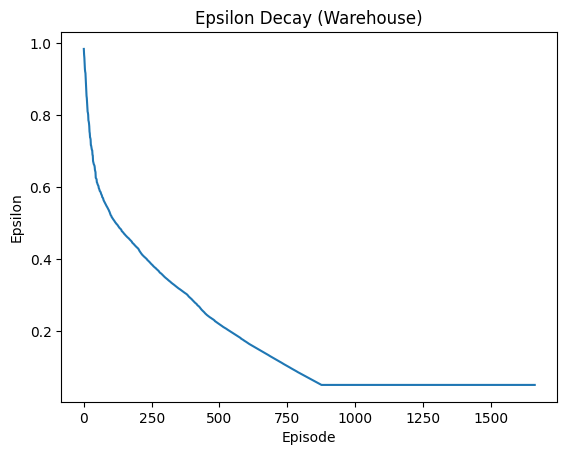

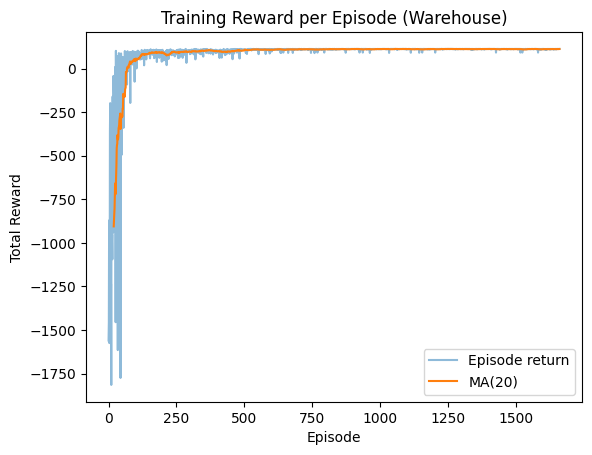

In [ ]:
def moving_avg(x, k=20):
    if len(x) < 1: return np.array([])
    k = max(1, int(k))
    c = np.cumsum(np.asarray(x, dtype=float))
    c[k:] = c[k:] - c[:-k]
    return c[k-1:] / k

# Epsilon vs Episode
plt.figure()
plt.plot(np.arange(len(episode_epsilons)), episode_epsilons)
plt.xlabel("Episode"); plt.ylabel("Epsilon"); plt.title("Epsilon Decay (Warehouse)")
plt.show()

# Total Reward per Episode and moving average
plt.figure()
plt.plot(np.arange(len(episode_returns)), episode_returns, alpha=0.5, label="Episode return")
ma = moving_avg(episode_returns, k=20)
if ma.size:
    plt.plot(np.arange(len(ma)) + (len(episode_returns)-len(ma)), ma, label="MA(20)")
plt.xlabel("Episode"); plt.ylabel("Total Reward"); plt.title("Training Reward per Episode (Warehouse)")
plt.legend(); plt.show()

## **2.1.12 Greedy evaluation (10 episodes) + quick plot**

Runs the learned policy with ε=0 for at 10 episodes, collects total returns, prints summary statistics, and plots a dot-line chart of greedy episode returns to document final performance.

Greedy returns: [113.0, 113.0, 113.0, 113.0, 113.0, 113.0, 113.0, 113.0, 113.0, 113.0] | mean: 113.0


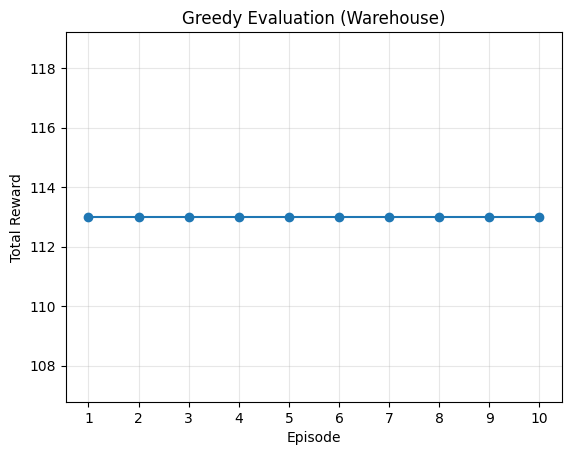

In [ ]:
@torch.no_grad()
def greedy_action(state_vec):
    s = torch.tensor(state_vec, dtype=torch.float32, device=device).unsqueeze(0)
    q = policy_net(s)
    return int(q.argmax(dim=1).item())

def evaluate_greedy(env, n_episodes=5, max_steps=1000, render=False):
    scores = []
    for ep in range(n_episodes):
        obs, info = env.reset()
        svec = one_hot_state(obs, env.n_rows, env.n_cols)
        total_r = 0.0
        for t in range(max_steps):
            a = greedy_action(svec)
            obs, r, term, trunc, _ = env.step(a)
            total_r += r
            if render:
                print(env.render())
            if term or trunc:
                break
            svec = one_hot_state(obs, env.n_rows, env.n_cols)
        scores.append(total_r)
    return scores

greedy_scores = evaluate_greedy(env, n_episodes=10, render=False)
print("Greedy returns:", greedy_scores, "| mean:", np.mean(greedy_scores))

episodes = np.arange(1, len(greedy_scores) + 1)

plt.figure()
plt.plot(episodes, greedy_scores, marker='o')  # line with dots
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Greedy Evaluation (Warehouse)")
plt.xticks(episodes)
plt.grid(True, alpha=0.3)
plt.show()

## **2.1.13 Greedy showcase: save each render step for one episode**

Captures the env’s text render at each greedy step, saves frames as ordered `.txt` files, and then displays them inline. This provides the step-by-step evidence that the agent completes pickup and delivery correctly.

In [ ]:
def render_to_string(env):
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        env.render()              # prints to stdout
    return buf.getvalue().rstrip()

def save_greedy_showcase(env, out_dir="warehouse_greedy_showcase", max_steps=1000):
    os.makedirs(out_dir, exist_ok=True)
    obs, info = env.reset()
    svec = one_hot_state(obs, env.n_rows, env.n_cols)
    i = 0
    while True:
        # capture frame BEFORE action (state at step i)
        frame_text = render_to_string(env)
        with open(os.path.join(out_dir, f"step_{i:03d}.txt"), "w") as f:
            f.write(frame_text + "\n")

        a = greedy_action(svec)
        obs, r, term, trunc, _ = env.step(a)
        i += 1
        if term or trunc or i >= max_steps:
            # final frame AFTER terminal/truncated
            frame_text = render_to_string(env)
            with open(os.path.join(out_dir, f"step_{i:03d}.txt"), "w") as f:
                f.write(frame_text + "\n")
            break
        svec = one_hot_state(obs, env.n_rows, env.n_cols)

    print(f"Saved {i+1} frames to: {out_dir}")

save_greedy_showcase(env, out_dir="warehouse_greedy_showcase")


Saved 13 frames to: warehouse_greedy_showcase


**Inline Preview**

In [ ]:
from IPython.display import Markdown, display
import glob


files = sorted(glob.glob("warehouse_greedy_showcase/step_*.txt"))


for i, path in enumerate(files):
    with open(path, "r") as f:
        txt = f.read().rstrip()
    display(Markdown(f"**Frame {i}**\n\n```text\n{txt}\n```"))


**Frame 0**

```text
[A] [.] [.] [.] [.] [P]
[.] [.] [#] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [#] [#] [.] [.] [.]
[.] [.] [.] [.] [.] [D]
pos=(0,0) carrying=False
```

**Frame 1**

```text
[.] [A] [.] [.] [.] [P]
[.] [.] [#] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [#] [#] [.] [.] [.]
[.] [.] [.] [.] [.] [D]
pos=(0,1) carrying=False
```

**Frame 2**

```text
[.] [.] [A] [.] [.] [P]
[.] [.] [#] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [#] [#] [.] [.] [.]
[.] [.] [.] [.] [.] [D]
pos=(0,2) carrying=False
```

**Frame 3**

```text
[.] [.] [.] [A] [.] [P]
[.] [.] [#] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [#] [#] [.] [.] [.]
[.] [.] [.] [.] [.] [D]
pos=(0,3) carrying=False
```

**Frame 4**

```text
[.] [.] [.] [.] [A] [P]
[.] [.] [#] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [#] [#] [.] [.] [.]
[.] [.] [.] [.] [.] [D]
pos=(0,4) carrying=False
```

**Frame 5**

```text
[.] [.] [.] [.] [.] [A]
[.] [.] [#] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [#] [#] [.] [.] [.]
[.] [.] [.] [.] [.] [D]
pos=(0,5) carrying=False
```

**Frame 6**

```text
[.] [.] [.] [.] [.] [a]
[.] [.] [#] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [#] [#] [.] [.] [.]
[.] [.] [.] [.] [.] [D]
pos=(0,5) carrying=True
```

**Frame 7**

```text
[.] [.] [.] [.] [.] [P]
[.] [.] [#] [#] [.] [a]
[.] [.] [.] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [#] [#] [.] [.] [.]
[.] [.] [.] [.] [.] [D]
pos=(1,5) carrying=True
```

**Frame 8**

```text
[.] [.] [.] [.] [.] [P]
[.] [.] [#] [#] [.] [.]
[.] [.] [.] [#] [.] [a]
[.] [.] [.] [#] [.] [.]
[.] [#] [#] [.] [.] [.]
[.] [.] [.] [.] [.] [D]
pos=(2,5) carrying=True
```

**Frame 9**

```text
[.] [.] [.] [.] [.] [P]
[.] [.] [#] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [.] [.] [#] [.] [a]
[.] [#] [#] [.] [.] [.]
[.] [.] [.] [.] [.] [D]
pos=(3,5) carrying=True
```

**Frame 10**

```text
[.] [.] [.] [.] [.] [P]
[.] [.] [#] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [#] [#] [.] [.] [a]
[.] [.] [.] [.] [.] [D]
pos=(4,5) carrying=True
```

**Frame 11**

```text
[.] [.] [.] [.] [.] [P]
[.] [.] [#] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [#] [#] [.] [.] [.]
[.] [.] [.] [.] [.] [a]
pos=(5,5) carrying=True
```

**Frame 12**

```text
[.] [.] [.] [.] [.] [P]
[.] [.] [#] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [.] [.] [#] [.] [.]
[.] [#] [#] [.] [.] [.]
[.] [.] [.] [.] [.] [A]
pos=(5,5) carrying=False
```

**Record a Grid-World greedy episode**

In [ ]:
os.makedirs("report_artifacts/videos", exist_ok=True)

# Use the same greedy policy and one_hot -> vector we already have
grid_cfg = WarehouseConfig()

def run_greedy_episode_video_grid(video_folder="report_artifacts/videos",
                                  max_steps=200, name="gridworld_greedy"):
    # Make an RGB-capable env instance
    make_env = lambda: WarehouseDeterministicEnv(grid_cfg, render_mode="rgb_array")
    env = RecordVideo(make_env(), video_folder=video_folder, name_prefix=name)

    obs, info = env.reset(seed=SEED)
    svec = one_hot_state(obs, grid_cfg.n_rows, grid_cfg.n_cols)
    for _ in range(max_steps):
        a = greedy_action(svec)  # the existing greedy_action for grid
        obs, r, term, trunc, _ = env.step(a)
        if term or trunc:
            break
        svec = one_hot_state(obs, grid_cfg.n_rows, grid_cfg.n_cols)
    env.close()
    print("Saved Grid-World video to:", video_folder)

run_greedy_episode_video_grid()

Saved Grid-World video to: report_artifacts/videos


## **2.1.14 Load weights helper**

Utility to reload saved model weights into both policy and target networks for later evaluation runs or reuse in other environments without retraining.

In [ ]:
def load_weights(path):
    state_dict = torch.load(path, map_location=device)
    policy_net.load_state_dict(state_dict)
    target_net.load_state_dict(state_dict)
    policy_net.eval(); target_net.eval()
    print("Loaded weights from:", path)

-------------

# **2.2 Applying DQN to solve various RL problems**

## **2.2.1 CartPole setup & observation utilities**

Creates the CartPole-v1 env, prints spaces, sets `state_size=obs_dim` and `n_actions`, and defines `to_vec()` that passes the raw 4-D observation through (DQN will take this vector directly without one-hot).

In [ ]:
cart_env = gym.make("CartPole-v1")
obs, info = cart_env.reset(seed=SEED)

# spaces & dims
print("CartPole action space:", cart_env.action_space)
print("CartPole observation space:", cart_env.observation_space)

cp_state_size = cart_env.observation_space.shape[0]   # 4
cp_n_actions  = cart_env.action_space.n               # 2
print("state_size:", cp_state_size, " | n_actions:", cp_n_actions)

def cp_to_vec(obs):
    """CartPole uses the raw 4D observation directly as the state vector."""
    return np.asarray(obs, dtype=np.float32)

CartPole action space: Discrete(2)
CartPole observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
state_size: 4  | n_actions: 2


## **2.2.2 CartPole DQN: network, buffer, config, ε-policy**

Initializes a Q-network (and target) sized for CartPole (from 4 to 2), a replay buffer, a config tuned for this task, and ε-greedy helpers specific to these models.

In [ ]:
ART_DIR = "report_artifacts"
os.makedirs(ART_DIR, exist_ok=True)

# Reuse the QNet definition from 2.1
policy_cp = QNet(cp_state_size, cp_n_actions, hidden=128).to(device)
target_cp = QNet(cp_state_size, cp_n_actions, hidden=128).to(device)
target_cp.load_state_dict(policy_cp.state_dict())
target_cp.eval()

# Optimizer
optimizer_cp = optim.AdamW(policy_cp.parameters(), lr=1e-3)

# Replay buffer
replay_cp = ReplayBuffer(capacity=50_000)

# Config (CartPole)
@dataclass
class DQNConfigCP:
    gamma: float = 0.99
    lr: float = 1e-3
    batch_size: int = 64
    start_training_after: int = 1_000
    train_freq: int = 1
    target_sync_every: int = 2_000
    max_steps: int = 150_000          # to make sure it reaches >470 avg in eval
    eps_start: float = 1.0
    eps_end: float = 0.05
    eps_decay_steps: int = 100_000     # slower decay for CartPole
    reward_clip: float | None = None   # keep un-clipped for CP
    save_path: str = "a2_part_2_dqn_cartpole_ellawela.pth"
    log_returns_path: str = os.path.join(ART_DIR, "cartpole_dqn_ep_returns.npy")
    log_eps_path: str     = os.path.join(ART_DIR, "cartpole_dqn_ep_eps.npy")

cfg_cp = DQNConfigCP()

# ε schedule + selector (CartPole nets)
def epsilon_by_step_cp(step):
    t = min(step / cfg_cp.eps_decay_steps, 1.0)
    return cfg_cp.eps_start + t * (cfg_cp.eps_end - cfg_cp.eps_start)

@torch.no_grad()
def select_action_cp(state_vec, step_count):
    eps = epsilon_by_step_cp(step_count)
    if random.random() < eps:
        return random.randrange(cp_n_actions), eps
    s = torch.tensor(state_vec, dtype=torch.float32, device=device).unsqueeze(0)
    q = policy_cp(s)
    a = int(q.argmax(dim=1).item())
    return a, eps

## **2.2.3 CartPole training loop (optimize, target sync, logging, save)**

Runs ε-greedy interaction on CartPole, stores transitions, does minibatch TD with Huber loss, periodically syncs target net, logs rewards and ε per episode, and saves weights.

In [ ]:
def optimize_step_cp():
    if len(replay_cp) < cfg_cp.start_training_after:
        return None
    s, a, r, s2, d = replay_cp.sample(cfg_cp.batch_size)

    # Q(s,a)
    q_sa = policy_cp(s).gather(1, a)

    # Target: r + gamma*(1-done)*max_a' Q_target(s',a')
    with torch.no_grad():
        q_next = target_cp(s2).max(dim=1, keepdim=True)[0]
        target = r + cfg_cp.gamma * (1.0 - d) * q_next

    loss = nn.SmoothL1Loss()(q_sa, target)
    optimizer_cp.zero_grad(set_to_none=True)
    loss.backward()
    # no grad clipping
    optimizer_cp.step()
    return float(loss.item())

def cp_vec(obs):
    return cp_to_vec(obs)

cp_ep_returns, cp_ep_lengths, cp_ep_eps = [], [], []
cp_global_step, cp_last_sync = 0, 0
cp_loss_ema = None
t0 = time.time()

obs, info = cart_env.reset(seed=SEED)
svec = cp_vec(obs)
ep_ret, ep_len = 0.0, 0

while cp_global_step < cfg_cp.max_steps:
    # ε-greedy
    a, eps = select_action_cp(svec, cp_global_step)

    # step env
    obs2, r, terminated, truncated, info = cart_env.step(a)
    done = terminated or truncated
    svec2 = cp_vec(obs2)

    # store
    replay_cp.push(svec, a, r, svec2, float(done))

    # optimize
    if (cp_global_step % cfg_cp.train_freq) == 0:
        loss = optimize_step_cp()
        if loss is not None:
            cp_loss_ema = loss if cp_loss_ema is None else 0.98 * cp_loss_ema + 0.02 * loss

    # target sync
    if (cp_global_step - cp_last_sync) >= cfg_cp.target_sync_every:
        target_cp.load_state_dict(policy_cp.state_dict())
        cp_last_sync = cp_global_step

    # episode accounting
    ep_ret += r
    ep_len += 1

    if done:
        cp_ep_returns.append(ep_ret)
        cp_ep_lengths.append(ep_len)
        cp_ep_eps.append(epsilon_by_step_cp(cp_global_step))

        obs, info = cart_env.reset()
        svec = cp_vec(obs)
        ep_ret, ep_len = 0.0, 0
    else:
        obs = obs2
        svec = svec2

    # progress log
    if (cp_global_step % 5000) == 0:
        loss_str = "None" if cp_loss_ema is None else f"{cp_loss_ema:.4f}"
        elapsed = (time.time() - t0) / 60.0
        print(f"step={cp_global_step:6d} eps={eps:5.3f} replay={len(replay_cp):6d} "
              f"loss~={loss_str} episodes={len(cp_ep_returns):4d} elapsed={elapsed:.1f}m")

    cp_global_step += 1

# save weights
torch.save(policy_cp.state_dict(), cfg_cp.save_path)
np.save(cfg_cp.log_returns_path, np.asarray(cp_ep_returns, dtype=np.float32))
np.save(cfg_cp.log_eps_path,np.asarray(cp_ep_eps, dtype=np.float32))
print("Saved CartPole weights to:", cfg_cp.save_path)

step=     0 eps=1.000 replay= 50000 loss~=0.1040 episodes=   0 elapsed=0.0m
step=  5000 eps=0.953 replay= 50000 loss~=0.6949 episodes= 242 elapsed=0.1m
step= 10000 eps=0.905 replay= 50000 loss~=0.8086 episodes= 449 elapsed=0.3m
step= 15000 eps=0.858 replay= 50000 loss~=0.4996 episodes= 678 elapsed=0.4m
step= 20000 eps=0.810 replay= 50000 loss~=0.7146 episodes= 929 elapsed=0.5m
step= 25000 eps=0.762 replay= 50000 loss~=0.5730 episodes=1179 elapsed=0.7m
step= 30000 eps=0.715 replay= 50000 loss~=0.5906 episodes=1419 elapsed=0.8m
step= 35000 eps=0.667 replay= 50000 loss~=0.5258 episodes=1666 elapsed=1.0m
step= 40000 eps=0.620 replay= 50000 loss~=0.4800 episodes=1912 elapsed=1.1m
step= 45000 eps=0.573 replay= 50000 loss~=0.5119 episodes=2182 elapsed=1.3m
step= 50000 eps=0.525 replay= 50000 loss~=0.3940 episodes=2410 elapsed=1.4m
step= 55000 eps=0.478 replay= 50000 loss~=0.3956 episodes=2600 elapsed=1.5m
step= 60000 eps=0.430 replay= 50000 loss~=0.4492 episodes=2754 elapsed=1.7m
step= 65000 

## **2.2.4 CartPole training plots (ε decay & reward per episode)**

Plots CartPole’s epsilon vs episode and total reward per episode with a 20-episode moving average to show learning progress.

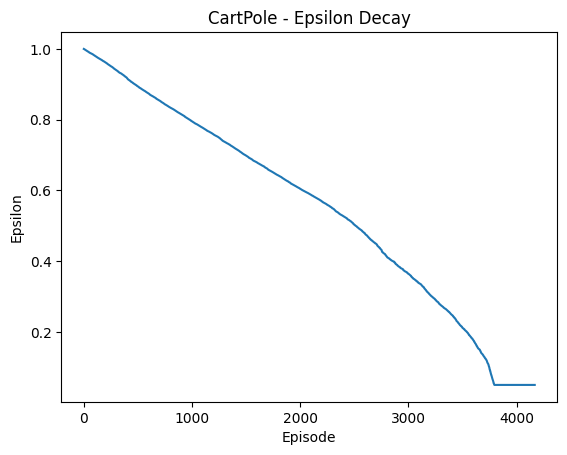

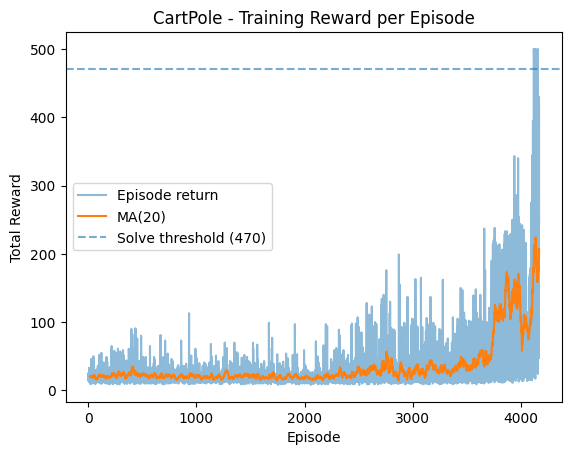

In [ ]:
def moving_avg(x, k=20):
    if len(x) < 1: return np.array([])
    k = max(1, int(k))
    c = np.cumsum(np.asarray(x, dtype=float))
    c[k:] = c[k:] - c[:-k]
    return c[k-1:] / k

# Epsilon vs Episode
plt.figure()
plt.plot(np.arange(1, len(cp_ep_eps)+1), cp_ep_eps)
plt.xlabel("Episode"); plt.ylabel("Epsilon"); plt.title("CartPole - Epsilon Decay")
plt.show()

# Total Reward per Episode and moving average
plt.figure()
plt.plot(np.arange(1, len(cp_ep_returns)+1), cp_ep_returns, alpha=0.5, label="Episode return")
ma = moving_avg(cp_ep_returns, k=20)
if ma.size:
    plt.plot(np.arange(len(ma)) + 1 + (len(cp_ep_returns)-len(ma)), ma, label="MA(20)")
plt.axhline(470, linestyle="--", alpha=0.6, label="Solve threshold (470)")
plt.xlabel("Episode"); plt.ylabel("Total Reward"); plt.title("CartPole - Training Reward per Episode")
plt.legend(); plt.show()

## **2.2.5 Greedy evaluation (10 eps) + dot-line plot & solve check**

Runs the learned policy with ε=0 for 10 episodes, reports per-episode returns, plots them (dot-line), and prints whether the average ≥ 470 (CartPole “solved”).

CartPole greedy returns: [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Mean greedy return: 500.0
Solved (mean ≥ 470)? True


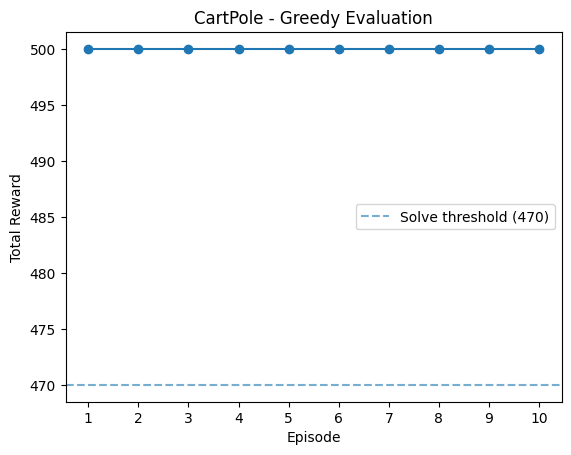

In [ ]:
@torch.no_grad()
def greedy_action_cp(state_vec):
    s = torch.tensor(state_vec, dtype=torch.float32, device=device).unsqueeze(0)
    q = policy_cp(s)
    return int(q.argmax(dim=1).item())

def evaluate_greedy_cp(env, n_episodes=10, max_steps=1000):
    scores = []
    for _ in range(n_episodes):
        obs, info = env.reset()
        svec = cp_to_vec(obs)
        total_r = 0.0
        for t in range(max_steps):
            a = greedy_action_cp(svec)
            obs, r, term, trunc, _ = env.step(a)
            total_r += r
            if term or trunc:
                break
            svec = cp_to_vec(obs)
        scores.append(total_r)
    return scores

cp_greedy_scores = evaluate_greedy_cp(cart_env, n_episodes=10, max_steps=1000)
print("CartPole greedy returns:", cp_greedy_scores)
print("Mean greedy return:", np.mean(cp_greedy_scores))
print("Solved (mean ≥ 470)?", np.mean(cp_greedy_scores) >= 470.0)

# dot-line plot
episodes = np.arange(1, len(cp_greedy_scores)+1)
plt.figure()
plt.plot(episodes, cp_greedy_scores, marker='o')
plt.axhline(470, linestyle='--', alpha=0.6, label='Solve threshold (470)')
plt.xlabel("Episode"); plt.ylabel("Total Reward"); plt.title("CartPole - Greedy Evaluation")
plt.xticks(episodes); plt.legend(); plt.show()

## **2.2.6 MountainCar setup & observation utilities**

Creates `MountainCar-v0`, prints spaces, sets `state_size=2` and `n_actions=3`, and defines `to_vec()` that passes the raw 2-D state (position, velocity) directly to the DQN.

In [ ]:
mc_env = gym.make("MountainCar-v0")
obs, info = mc_env.reset(seed=SEED)

print("MountainCar action space:", mc_env.action_space)       # Discrete(3)
print("MountainCar observation space:", mc_env.observation_space)  # Box(2,)

mc_state_size = mc_env.observation_space.shape[0]  # 2
mc_n_actions  = mc_env.action_space.n              # 3
print("state_size:", mc_state_size, " | n_actions:", mc_n_actions)

def mc_to_vec(obs):
    """MountainCar uses the raw 2D observation directly as the state vector."""
    return np.asarray(obs, dtype=np.float32)

MountainCar action space: Discrete(3)
MountainCar observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
state_size: 2  | n_actions: 3


## **2.2.7 MountainCar DQN: network, buffer, config, ε-policy**

Initializes a Q-network (and target) sized for MountainCar (from 2 to 3 ), a replay buffer, a config tuned for this task, a light obs normalizer (scale to ~[−1,1] using env bounds), and ε-greedy helpers.

In [ ]:
ART_DIR = "report_artifacts"
os.makedirs(ART_DIR, exist_ok=True)

# Reuse QNet and ReplayBuffer from earlier cells
policy_mc = QNet(mc_state_size, mc_n_actions, hidden=128).to(device)
target_mc = QNet(mc_state_size, mc_n_actions, hidden=128).to(device)
target_mc.load_state_dict(policy_mc.state_dict())
target_mc.eval()

optimizer_mc = optim.AdamW(policy_mc.parameters(), lr=1e-3)
replay_mc = ReplayBuffer(capacity=50_000)

# Config (MountainCar)
@dataclass
class DQNConfigMC:
    gamma: float = 0.99
    lr: float = 1e-3
    batch_size: int = 64
    start_training_after: int = 1_000
    train_freq: int = 1
    target_sync_every: int = 2_000
    max_steps: int = 200_000          # MC is harder; therefore gave it more steps
    eps_start: float = 1.0
    eps_end: float = 0.05
    eps_decay_steps: int = 150_000     # slow, to keep exploring long enough
    reward_clip: float | None = None   # keep original rewards for training
    save_path: str = "a2_part_2_dqn_mountaincar_ellawela.pth"
    log_returns_path: str = os.path.join(ART_DIR, "mountaincar_dqn_ep_returns.npy")
    log_eps_path: str     = os.path.join(ART_DIR, "mountaincar_dqn_ep_eps.npy")

cfg_mc = DQNConfigMC()

# Light normalization to stabilize learning
mc_low  = mc_env.observation_space.low.astype(np.float32)
mc_high = mc_env.observation_space.high.astype(np.float32)
# velocity bounds are small; clip finite to avoid inf
mc_low  = np.where(np.isfinite(mc_low),  mc_low,  -1.0)
mc_high = np.where(np.isfinite(mc_high), mc_high, +1.0)

def mc_to_vec_norm(obs):
    obs = mc_to_vec(obs)
    # scale roughly to [-1, 1]
    return np.clip(2.0 * (obs - mc_low) / (mc_high - mc_low + 1e-8) - 1.0, -5.0, 5.0).astype(np.float32)

# ε schedule + selector (MountainCar nets)
def epsilon_by_step_mc(step):
    t = min(step / cfg_mc.eps_decay_steps, 1.0)
    return cfg_mc.eps_start + t * (cfg_mc.eps_end - cfg_mc.eps_start)

@torch.no_grad()
def select_action_mc(state_vec, step_count):
    eps = epsilon_by_step_mc(step_count)
    if random.random() < eps:
        return random.randrange(mc_n_actions), eps
    s = torch.tensor(state_vec, dtype=torch.float32, device=device).unsqueeze(0)
    q = policy_mc(s)
    a = int(q.argmax(dim=1).item())
    return a, eps

## **2.2.8 MountainCar training loop (optimize, target sync, logging, save)**

Runs ε-greedy interaction on MountainCar, stores transitions, does minibatch TD with Huber loss, periodically syncs target net, logs rewards and ε per episode, and saves weights.

In [ ]:
def optimize_step_mc():
    if len(replay_mc) < cfg_mc.start_training_after:
        return None
    s, a, r, s2, d = replay_mc.sample(cfg_mc.batch_size)

    q_sa = policy_mc(s).gather(1, a)
    with torch.no_grad():
        q_next = target_mc(s2).max(dim=1, keepdim=True)[0]
        target = r + cfg_mc.gamma * (1.0 - d) * q_next

    loss = nn.SmoothL1Loss()(q_sa, target)
    optimizer_mc.zero_grad(set_to_none=True)
    loss.backward()
    optimizer_mc.step()
    return float(loss.item())

def mc_vec(obs):
    return mc_to_vec_norm(obs)  # normalized 2D state

mc_ep_returns, mc_ep_lengths, mc_ep_eps = [], [], []
mc_global_step, mc_last_sync = 0, 0
mc_loss_ema = None
t0 = time.time()

obs, info = mc_env.reset(seed=SEED)
svec = mc_vec(obs)
ep_ret, ep_len = 0.0, 0

while mc_global_step < cfg_mc.max_steps:
    a, eps = select_action_mc(svec, mc_global_step)

    obs2, r, terminated, truncated, info = mc_env.step(a)
    done = terminated or truncated
    svec2 = mc_vec(obs2)

    replay_mc.push(svec, a, r, svec2, float(done))

    if (mc_global_step % cfg_mc.train_freq) == 0:
        loss = optimize_step_mc()
        if loss is not None:
            mc_loss_ema = loss if mc_loss_ema is None else 0.98 * mc_loss_ema + 0.02 * loss

    if (mc_global_step - mc_last_sync) >= cfg_mc.target_sync_every:
        target_mc.load_state_dict(policy_mc.state_dict())
        mc_last_sync = mc_global_step

    ep_ret += r
    ep_len += 1

    if done:
        mc_ep_returns.append(ep_ret)
        mc_ep_lengths.append(ep_len)
        mc_ep_eps.append(epsilon_by_step_mc(mc_global_step))
        obs, info = mc_env.reset()
        svec = mc_vec(obs)
        ep_ret, ep_len = 0.0, 0
    else:
        obs = obs2
        svec = svec2

    if (mc_global_step % 5000) == 0:
        loss_str = "None" if mc_loss_ema is None else f"{mc_loss_ema:.4f}"
        elapsed = (time.time() - t0) / 60.0
        print(f"step={mc_global_step:6d} eps={eps:5.3f} replay={len(replay_mc):6d} "
              f"loss~={loss_str} episodes={len(mc_ep_returns):4d} elapsed={elapsed:.1f}m")

    mc_global_step += 1

# save weights
torch.save(policy_mc.state_dict(), cfg_mc.save_path)
np.save(cfg_mc.log_returns_path, np.asarray(mc_ep_returns, dtype=np.float32))
np.save(cfg_mc.log_eps_path,     np.asarray(mc_ep_eps, dtype=np.float32))
print("Saved MountainCar weights to:", cfg_mc.save_path)

step=     0 eps=1.000 replay=     1 loss~=None episodes=   0 elapsed=0.0m
step=  5000 eps=0.968 replay=  5001 loss~=0.0073 episodes=  25 elapsed=0.2m
step= 10000 eps=0.937 replay= 10001 loss~=0.0150 episodes=  50 elapsed=0.4m
step= 15000 eps=0.905 replay= 15001 loss~=0.0217 episodes=  75 elapsed=0.7m
step= 20000 eps=0.873 replay= 20001 loss~=0.0424 episodes= 100 elapsed=0.9m
step= 25000 eps=0.842 replay= 25001 loss~=0.0652 episodes= 125 elapsed=1.2m
step= 30000 eps=0.810 replay= 30001 loss~=0.0709 episodes= 150 elapsed=1.4m
step= 35000 eps=0.778 replay= 35001 loss~=0.0800 episodes= 175 elapsed=1.7m
step= 40000 eps=0.747 replay= 40001 loss~=0.0805 episodes= 200 elapsed=2.0m
step= 45000 eps=0.715 replay= 45001 loss~=0.0764 episodes= 225 elapsed=2.2m
step= 50000 eps=0.683 replay= 50000 loss~=0.0932 episodes= 250 elapsed=2.5m
step= 55000 eps=0.652 replay= 50000 loss~=0.1067 episodes= 275 elapsed=2.7m
step= 60000 eps=0.620 replay= 50000 loss~=0.1225 episodes= 300 elapsed=3.0m
step= 65000 ep

## **2.2.9 MountainCar training plots (ε decay & reward per episode)**

Plots epsilon vs episode and total reward per episode with a 20-episode moving average.

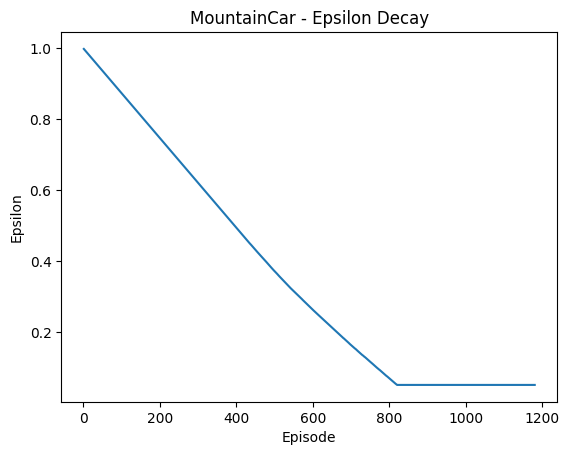

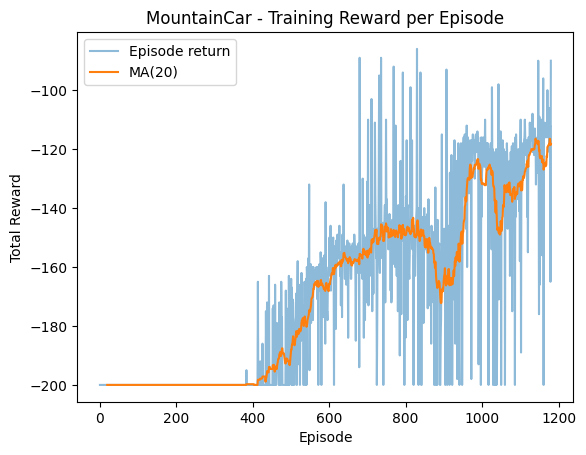

In [ ]:
def moving_avg(x, k=20):
    if len(x) < 1: return np.array([])
    k = max(1, int(k))
    c = np.cumsum(np.asarray(x, dtype=float))
    c[k:] = c[k:] - c[:-k]
    return c[k-1:] / k

# Epsilon vs Episode
plt.figure()
plt.plot(np.arange(1, len(mc_ep_eps)+1), mc_ep_eps)
plt.xlabel("Episode"); plt.ylabel("Epsilon"); plt.title("MountainCar - Epsilon Decay")
plt.show()

# Total Reward per Episode and moving average
plt.figure()
plt.plot(np.arange(1, len(mc_ep_returns)+1), mc_ep_returns, alpha=0.5, label="Episode return")
ma = moving_avg(mc_ep_returns, k=20)
if ma.size:
    plt.plot(np.arange(len(ma)) + 1 + (len(mc_ep_returns)-len(ma)), ma, label="MA(20)")
plt.xlabel("Episode"); plt.ylabel("Total Reward"); plt.title("MountainCar - Training Reward per Episode")
plt.legend(); plt.show()

## **2.2.10 MountainCar greedy evaluation (10 eps) + dot-line plot & success rate**

Runs ε=0 for 10 episodes, reports per-episode returns, plots them, and prints how many episodes reached the goal (terminated=True). MountainCar has no standard “solve” score, therefore, the success is reaching the flag within 200 steps.

MountainCar greedy returns: [-106.0, -106.0, -107.0, -106.0, -85.0, -106.0, -84.0, -107.0, -107.0, -106.0]
Mean greedy return: -102.0
Successes (reached goal): 10/10


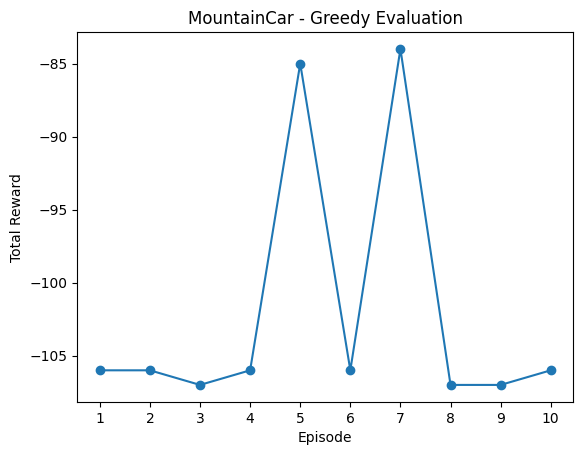

In [ ]:
@torch.no_grad()
def greedy_action_mc(state_vec):
    s = torch.tensor(state_vec, dtype=torch.float32, device=device).unsqueeze(0)
    q = policy_mc(s)
    return int(q.argmax(dim=1).item())

def evaluate_greedy_mc(env, n_episodes=10, max_steps=200):
    scores, successes = [], 0
    for _ in range(n_episodes):
        obs, info = env.reset()
        svec = mc_vec(obs)
        total_r = 0.0
        for t in range(max_steps):
            a = greedy_action_mc(svec)
            obs, r, term, trunc, _ = env.step(a)
            total_r += r
            if term:        # reached goal
                successes += 1
                break
            if trunc:       # time limit
                break
            svec = mc_vec(obs)
        scores.append(total_r)
    return scores, successes

mc_greedy_scores, mc_successes = evaluate_greedy_mc(mc_env, n_episodes=10, max_steps=200)
print("MountainCar greedy returns:", mc_greedy_scores)
print("Mean greedy return:", np.mean(mc_greedy_scores))
print(f"Successes (reached goal): {mc_successes}/10")

# dot-line plot
episodes = np.arange(1, len(mc_greedy_scores)+1)
plt.figure()
plt.plot(episodes, mc_greedy_scores, marker='o')
plt.xlabel("Episode"); plt.ylabel("Total Reward")
plt.title("MountainCar - Greedy Evaluation")
plt.xticks(episodes)
plt.show()

## **2.2.11 Save report artifacts (plots & short greedy videos)**

Saves the key plots to disk and records a single greedy evaluation episode video for each Gymnasium env (CartPole + MountainCar) using RecordVideo (standard Gym way).

In [ ]:
os.makedirs("report_artifacts", exist_ok=True)

# Save CartPole plots
plt.figure()
plt.plot(np.arange(1, len(cp_ep_eps)+1), cp_ep_eps)
plt.xlabel("Episode"); plt.ylabel("Epsilon"); plt.title("CartPole — Epsilon Decay")
plt.savefig("report_artifacts/cartpole_eps_decay.png", bbox_inches="tight"); plt.close()

plt.figure()
plt.plot(np.arange(1, len(cp_ep_returns)+1), cp_ep_returns, alpha=0.5, label="Episode return")
def moving_avg(x, k=20):
    if len(x) < 1: return np.array([])
    k = max(1, int(k)); c = np.cumsum(np.asarray(x, dtype=float))
    c[k:] = c[k:] - c[:-k]; return c[k-1:] / k
ma = moving_avg(cp_ep_returns, k=20)
if ma.size:
    plt.plot(np.arange(len(ma)) + 1 + (len(cp_ep_returns)-len(ma)), ma, label="MA(20)")
plt.axhline(470, linestyle="--", alpha=0.6, label="Solve threshold (470)")
plt.xlabel("Episode"); plt.ylabel("Total Reward"); plt.title("CartPole — Training Reward per Episode")
plt.legend()
plt.savefig("report_artifacts/cartpole_train_rewards.png", bbox_inches="tight"); plt.close()

# Save MountainCar plots
plt.figure()
plt.plot(np.arange(1, len(mc_ep_eps)+1), mc_ep_eps)
plt.xlabel("Episode"); plt.ylabel("Epsilon"); plt.title("MountainCar — Epsilon Decay")
plt.savefig("report_artifacts/mountaincar_eps_decay.png", bbox_inches="tight"); plt.close()

plt.figure()
plt.plot(np.arange(1, len(mc_ep_returns)+1), mc_ep_returns, alpha=0.5, label="Episode return")
ma2 = moving_avg(mc_ep_returns, k=20)
if ma2.size:
    plt.plot(np.arange(len(ma2)) + 1 + (len(mc_ep_returns)-len(ma2)), ma2, label="MA(20)")
plt.xlabel("Episode"); plt.ylabel("Total Reward"); plt.title("MountainCar — Training Reward per Episode")
plt.legend()
plt.savefig("report_artifacts/mountaincar_train_rewards.png", bbox_inches="tight"); plt.close()

# Record one greedy episode video for each env (standard Gym wrapper)
from gymnasium.wrappers import RecordVideo

def run_greedy_episode_video(make_env_fn, video_folder, greedy_fn, to_vec_fn,
                             max_steps=1000, name="eval_run"):
    env = RecordVideo(make_env_fn(), video_folder=video_folder, name_prefix=name)
    obs, info = env.reset(seed=SEED)
    svec = to_vec_fn(obs)
    for _ in range(max_steps):
        a = greedy_fn(svec)
        obs, r, term, trunc, _ = env.step(a)
        if term or trunc:
            break
        svec = to_vec_fn(obs)
    env.close()

# CartPole greedy video
os.makedirs("report_artifacts/videos", exist_ok=True)
run_greedy_episode_video(
    make_env_fn=lambda: gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder="report_artifacts/videos",
    greedy_fn=greedy_action_cp,
    to_vec_fn=cp_to_vec,
    max_steps=1000,
    name="cartpole_greedy"
)

# MountainCar greedy video
run_greedy_episode_video(
    make_env_fn=lambda: gym.make("MountainCar-v0", render_mode="rgb_array"),
    video_folder="report_artifacts/videos",
    greedy_fn=greedy_action_mc,
    to_vec_fn=mc_vec,
    max_steps=200,
    name="mountaincar_greedy"
)

print("Saved videos to: report_artifacts/videos/")


Saved videos to: report_artifacts/videos/
